# Ensemble Learning

In [442]:
import sys
import sklearn
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### The law of large numbers

Suppose you have a slightly biased coin that has a 51% chance of coming up heads and
49% chance of coming up tails. If you toss it 1,000 times, you will generally get more
or less 510 heads and 490 tails, and hence a majority of heads. If you do the math, you
will find that the probability of obtaining a majority of heads after 1,000 tosses is close
to 75%. The more you toss the coin, the higher the probability (e.g., with 10,000 tosses,
the probability climbs over 97%). This is due to the law of large numbers: as you keep
tossing the coin, the ratio of heads gets closer and closer to the probability of heads
(51%). The figure below shows 10 series of biased coin tosses. You can see that as the number
of tosses increases, the ratio of heads approaches 51%. Eventually all 10 series end up
so close to 51% that they are consistently above 50%.

Similarly, suppose you build an ensemble containing 1,000 classifiers that are
individually correct only 51% of the time (barely better than random guessing). If you
predict the majority voted class, you can hope for up to 75% accuracy! However, this is 
only true if all classifiers are perfectly independent, making uncorrelated errors, which
is clearly not the case because they are trained on the same data. They are likely to make
the same types of errors, so there will be many majority votes for the wrong class,
reducing the ensemble’s accuracy.

Let's setup an experiment of coss tosses and understand the power of repeating the experiment several times.

In [443]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

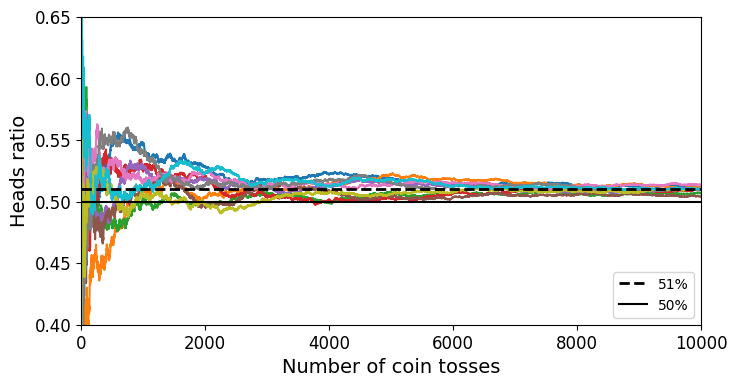

In [444]:
plt.figure(figsize=(8,4))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.4, 0.65])
#save_fig("law_of_large_numbers_plot")
plt.show()

### What is the confidence interval?

A [confidence interval](https://en.wikipedia.org/wiki/Confidence_interval) is the mean of your estimate plus and minus the variation in that estimate. This is the range of values you expect your estimate to fall between if you redo your test, within a certain level of confidence.

Confidence, in statistics, is another way to describe probability. For example, if you construct a confidence interval with a 95% confidence level, you are confident that 95 out of 100 times the estimate will fall between the upper and lower values specified by the confidence interval.  Your desired confidence level is usually one minus the alpha ($\alpha$) value you used in your statistical test:

Confidence level = $1 - \alpha$

So if you use an $\alpha$ value of p < 0.05 for statistical significance, then your confidence level would be $1 - 0.05 = 0.95$, or $95\%$.

The uncorrected p-value at 95% confidence interval is 0.05.

To calculate a 95% confidence interval, we first need to calculate the standard error. 

We can use the formula: $SE = \frac{\sigma}{\sqrt{n}}$, where $SE$ is the Standard Error, $\sigma$ is the sample standard deviation and $n$ is the number of data points.

Now let's estimate the margin of error as $ME = SE \times \mathbf{Z}(0.95)$, where $\mathbf{Z}(0.95)$ is the Z-score for 95% confidence level; you'll find this value in the statistical tables.

The only thing left is to count the lower and upper bounds of our confidence interval. To do this, we will add and subtract the margin of error to the mean (average, $\mu$).

$UB = \mu + ME, LB = \mu - ME$

![image](ci.png)

In [445]:
from pandas import read_csv
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
import numpy as np
from tqdm import tqdm

# load dataset
data = read_csv('pima-indians-diabetes.data', header=None)
values = data.values

data

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


Let's setup an experiment to perform classification in a bagging style. Essentially, we generate a lot of samples from the same dataset and build models on each of the samples.  Upon aggregating the results from every bag, the expectation is that the overall classification performance will improve.  Let's use PIMA dataset and a simple DecisionTree classifier to run the exercise.

In [446]:
# configure bootstrap
n_iterations = 500               # Number of bootstrap samples to create
n_size = int(len(data) * 0.50)    # picking only 50 % of the given data in every bootstrap sample

# run bootstrap
stats = list()
for i in tqdm(range(n_iterations)):
	# prepare train and test sets
	train = resample(values, n_samples=n_size)  # Sampling with replacement 
	test = np.array([x for x in values if x.tolist() not in train.tolist()])  # picking rest of the data not considered in sample

    # fit model
	model = DecisionTreeClassifier() #max_depth=1)  # we have DecisionStump here
	model.fit(train[:,:-1], train[:,-1])

    # evaluate model
	predictions = model.predict(test[:,:-1])
	score = accuracy_score(test[:,-1], predictions)    # caution, overall accuracy score can mislead when classes are imbalanced

	#print(score)
	stats.append(score)

print(stats[:10])

print("Mean:", np.mean(stats), "Std:", np.std(stats))

100%|██████████| 500/500 [00:23<00:00, 21.72it/s]

[0.7115384615384616, 0.6811279826464208, 0.6961206896551724, 0.7106382978723405, 0.6702586206896551, 0.6595744680851063, 0.6866952789699571, 0.7041036717062635, 0.7155361050328227, 0.6963123644251626]
Mean: 0.6887596079269813 Std: 0.020883822482018043


Let's see the histogram view of the results.

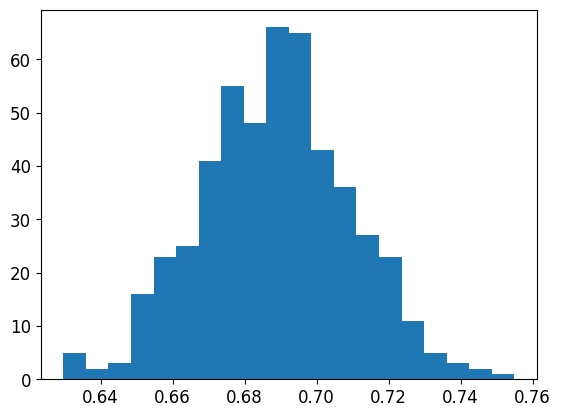

In [447]:
# plot scores
pyplot.hist(stats, 20)
pyplot.show()

Let's set the p-value to be 0.05, which will get us our 95% confidence interval.

In [448]:
import scipy.stats as st
import math

mean = round(np.mean(stats), 4)
std = round(np.std(stats), 4)

# confidence intervals
ci = 0.95
alpha = 1 - ci
n_sides = 2

print("alpha:", round(alpha, 4))
print("Confidence:", round(ci, 4))
print("Sides:", n_sides)

alpha: 0.05
Confidence: 0.95
Sides: 2


Let's compute the Standard Error (SE) and the Margin of Error (ME).  Followed by computing the Lower Bound (LB) and Upper Bound (UB)

In [449]:
#Ref: https://stackoverflow.com/questions/20864847/probability-to-z-score-and-vice-versa

SE = round(std/math.sqrt(n_iterations),5)
Z_critical = st.norm.ppf(1-alpha/n_sides)
ME = round(SE * Z_critical, 5)

print("Z-score:", Z_critical)
print("Standard Error:", SE)
print("Margin of Error:", ME)

ub = round(mean + ME, 4)
lb = round(mean - ME, 4)

print("95% Confidence Interval: ", lb, "to", ub)
print(f"95% of samples contain the population mean (μ={mean}) within the confidence interval ({ci}%) is x̅ ± E  => ", mean, "±", ME)

Z-score: 1.959963984540054
Standard Error: 0.00093
Margin of Error: 0.00182
95% Confidence Interval:  0.687 to 0.6906
95% of samples contain the population mean (μ=0.6888) within the confidence interval (0.95%) is x̅ ± E  =>  0.6888 ± 0.00182


### Voting Classifiers

Let's use the moons dataset:

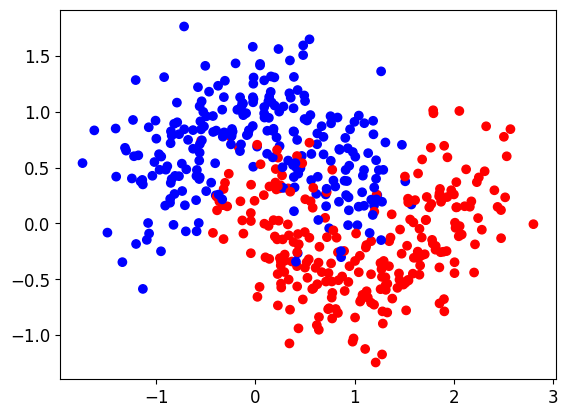

In [450]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import matplotlib.colors as colors

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
plt.scatter(X[:,0], X[:,1], c=y, cmap=colors.ListedColormap(["blue", "red"]))
plt.show()

**Note**: We set `solver="lbfgs"`, `n_estimators=100`, and `gamma="scale"` since these will be the default values in upcoming Scikit-Learn versions.

In [451]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

# If 'hard', uses predicted class labels for majority rule voting.
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [452]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [453]:
from sklearn.metrics import accuracy_score
import pandas as pd

df_data = {}
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
    df_data[clf.__class__.__name__] = y_pred

df = pd.DataFrame(df_data)    
# see row 22, where RF and LR have upvoted for "1" and SVC has predicted "0"
df[20:25]


LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


,LogisticRegression,RandomForestClassifier,SVC,VotingClassifier
20,0,0,0,0
21,1,1,1,1
22,1,1,0,1
23,0,0,0,0
24,0,0,0,0


In [454]:
# see row 88, where LR and SVC have upvoted for "1" and RF has predicted "0"
df[86:90]

,LogisticRegression,RandomForestClassifier,SVC,VotingClassifier
86,1,0,1,1
87,0,0,0,0
88,1,1,1,1
89,1,1,1,1


Soft voting:

In [455]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

# soft voting: predicts the class label based on the argmax of the sums of the predicted probabilities
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [456]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


### Bagging (Bootstrap Aggregating)

Let's repeat our previous experiment formally using sklearn packages.  To perform Bagging, we can directly use the BaggingClassifier class, which will inherently perform (bootstrap, i.e., sample with replacement) sampling, fitting the model and aggregating the results.

In [457]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,    # max_depth = 2, n_estimators = 20
    max_samples=100, bootstrap=True, random_state=42)  # max_samples = 300
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print("Bagging Performance:", accuracy_score(y_test, y_pred))

Bagging Performance: 0.904


Let's find out the performance of the base_classifier.


In [458]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print("Base Classifier Performance:", accuracy_score(y_test, y_pred_tree))

Base Classifier Performance: 0.856


**A single Decision Tree (left) versus a bagging ensemble of 500 trees (right):**

In [459]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "y.", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "b.", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)


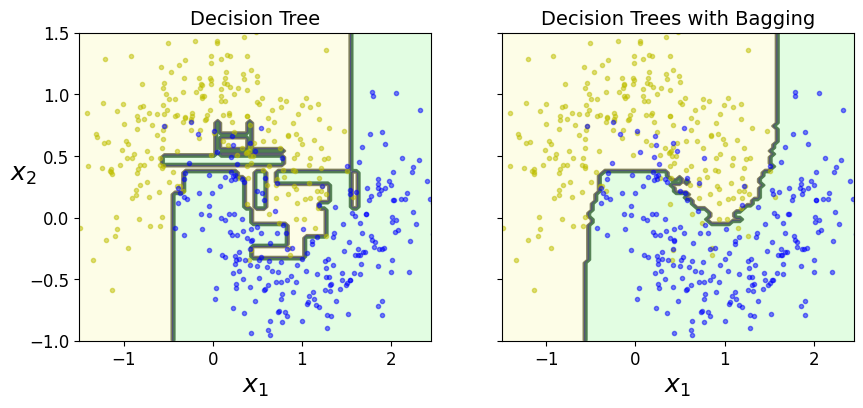

In [460]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

## Out-of-Bag evaluation

In [461]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_
#bag_clf.oob_decision_function_

0.8986666666666666

In [462]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

__we find that the performance of the classifier has increased a bit, because of the OOB training__

### Random Forests

In [463]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

A Random Forest is equivalent to a bag of decision trees:

In [464]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

In [465]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [466]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # very similar predictions

1.0

### Feature Importance

In [467]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


The following figure overlays the decision boundaries of 15 decision trees. As you can see, even though each decision tree is imperfect, the ensemble defines a pretty good decision boundary:

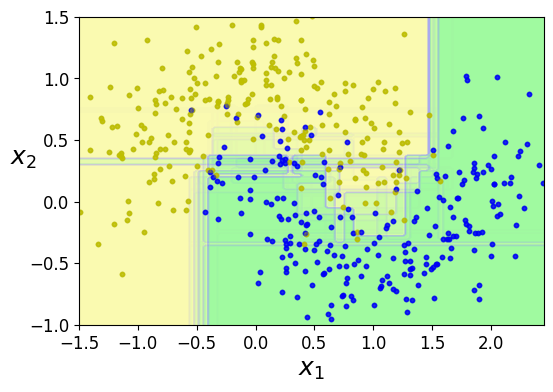

In [468]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.1, contour=False)

plt.show()

**MNIST pixel importance (according to a Random Forest classifier):**

In [469]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [470]:
rnd_clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [471]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


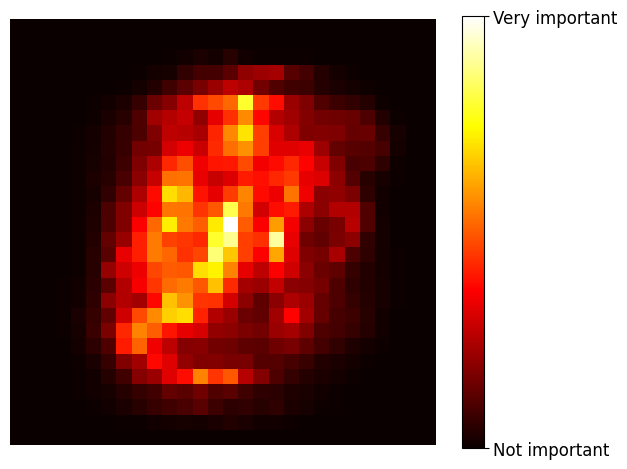

In [472]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

### AdaBoost

One way for a new predictor to correct its predecessor is to pay a bit more attention to
the training instances that the predecessor underfitted. This results in new predictors
focusing more and more on the hard cases. This is the technique used by AdaBoost.
For example, when training an AdaBoost classifier, the algorithm first trains a base
classifier (such as a Decision Tree) and uses it to make predictions on the training set.
The algorithm then increases the relative weight of misclassified training instances.
Then it trains a second classifier, using the updated weights, and again makes
predictions on the training set, updates the instance weights, and so on.

Let's consider Adaboost for learning a classifier on our moon dataset and visualize the decision boundary.

In [481]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), 
    #SVC(C=0.2, gamma=0.6, random_state=42),
    n_estimators=200,
    algorithm="SAMME", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

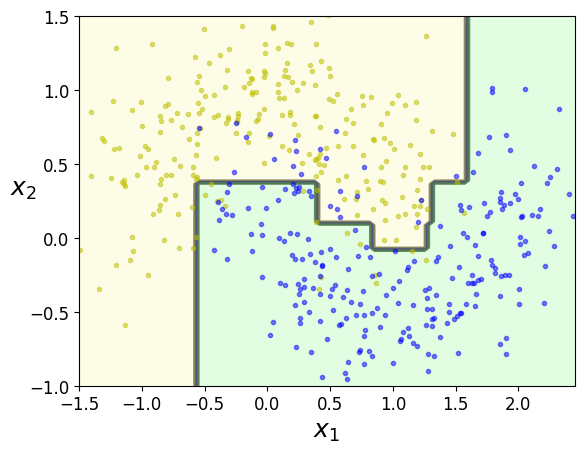

In [482]:
plot_decision_boundary(ada_clf, X, y)

**Decision boundaries of consecutive predictors, which are learned during the Boosting iterations**

Equation 1: $r_j = \underset{\hat{y}_j^{(i)}\ne y^{(i)}} {\sum_{i=1}^{m}} w^{(i)}$, where $\hat{y}_j^{(i)}$ is the $j^{th}$ predictor's prediction of the $i^{th}$ instance.

Equation 2:  $\alpha_j = \eta\log\frac {1-r_j}{r_j}$, the default value of $\eta$ is $\frac{1}{2}$, but we are going to use it as the `learning_rate` parameter.

Equation 3: $w^{(i)} \leftarrow \begin{cases} 
      w^{(i)} & \text{if } \hat{y}_j^{(i)}=y^{(i)} \\
      w^{(i)}\exp(\alpha_j) & \text{if } \hat{y}_j^{(i)}\ne y^{(i)} 
\end{cases}
$

100%|██████████| 5/5 [00:00<00:00, 11.00it/s]


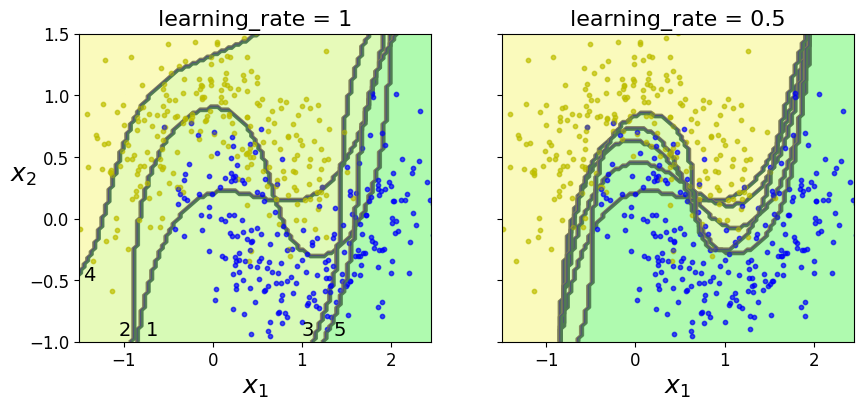

In [490]:
m = len(X_train)
ids = np.arange(m)
EXPLICIT_SAMPLING = False

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)): 
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in tqdm(range(5)):
        # we can use the estimated sample_weights to draw a bootstrap sample.
        if EXPLICIT_SAMPLING:
            sampled_ids = np.random.choice(ids, m, p=sample_weights)
            X_iter = X_train[sampled_ids]
            y_iter = y_train[sampled_ids]

        # Note: RBF is not a weak classifier.  We may consider linear kernel also.
        #svm_clf = SVC(kernel='linear', C=0.1, random_state=42)
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        #svm_clf = DecisionTreeClassifier(max_depth=3, random_state=42)

        if not EXPLICIT_SAMPLING:
            # we can either use the inherent sampler that comes with the fit() method.
            # Note: different algorithms may require the sample_weights to be scaled or unscaled!
            svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        else:
            # Or use our resampled data to run the model training.
            svm_clf.fit(X_iter, y_iter)
        
        # The prediction has to be for the full training partition.
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 1
        alpha = learning_rate * np.log((1 - r) / r) if r != 0 else 0.0   # equation 2 
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 3
        # we may also decrease the weights of the correctly classified point to accentuate the effect.
        #sample_weights[y_pred == y_train] *= np.exp(-alpha) # equation 3
        sample_weights /= sample_weights.sum() # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0 and not EXPLICIT_SAMPLING:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

## Gradient Boosting

Another very popular boosting algorithm is Gradient Boosting. Just like AdaBoost,
Gradient Boosting works by sequentially adding predictors to an ensemble, each one
correcting its predecessor. However, instead of tweaking the instance weights at every
iteration like AdaBoost does, this method tries to fit the new predictor to the residual
errors made by the previous predictor.

Let create a simple quadratic dataset:

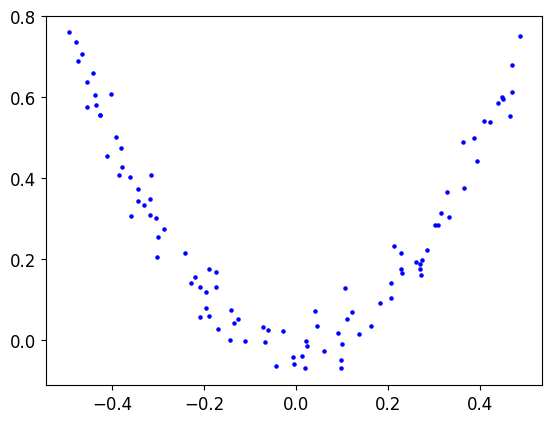

In [491]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)
plt.scatter(X, y, s=5, c='b')

Now let's train a decision tree regressor on this dataset:

In [492]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Let's plot the predicted points over the original points to understand the fit.

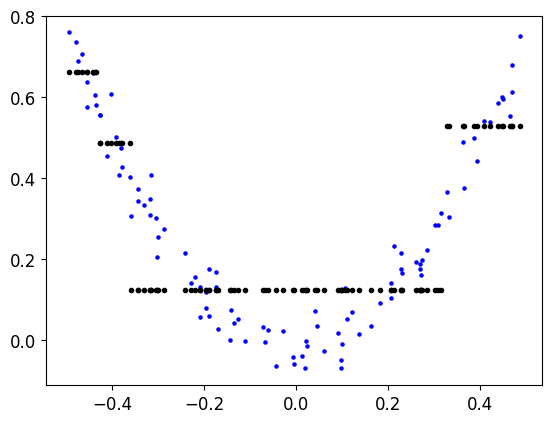

In [493]:
yhat1 = tree_reg1.predict(X)
plt.scatter(X, y, c='b', s=5)
plt.plot(X, yhat1, 'k.')


Let's compute the residuals and visualize them.

Text(0, 0.5, 'y')

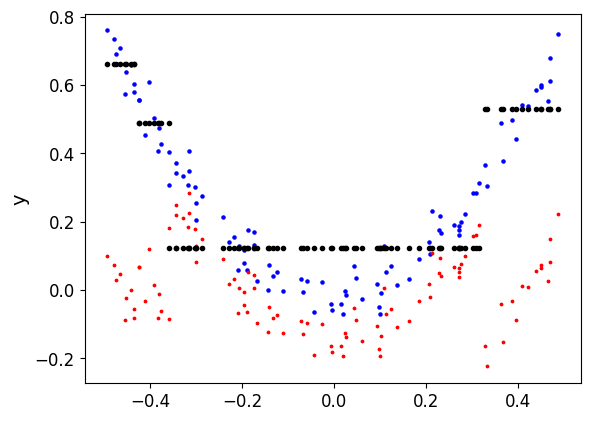

In [494]:
residual1 = y - yhat1
plt.scatter(X, y, s=5, c='b')
plt.plot(X, yhat1, 'k.', )
plt.scatter(X, residual1, c='r', s=3)
plt.ylabel("y")

Let's build the next regressor to fit the residuals.

In [495]:
# here the residuals from the previous model is the target variable.
y2 = y - tree_reg1.predict(X) 
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Let's plot the predicted points `yhat2` over the original points `y2` to understand the fit.

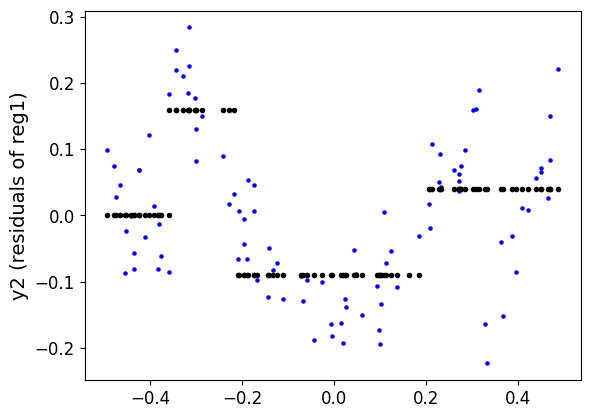

In [496]:
yhat2 = tree_reg2.predict(X)
plt.scatter(X, y2, c='b', s=5)
plt.plot(X, yhat2, 'k.')
plt.ylabel('y2 (residuals of reg1)')
plt.show()

Let's compute the residuals of `reg2` and visualize them.

Text(0, 0.5, 'y2 (residuals from reg1)')

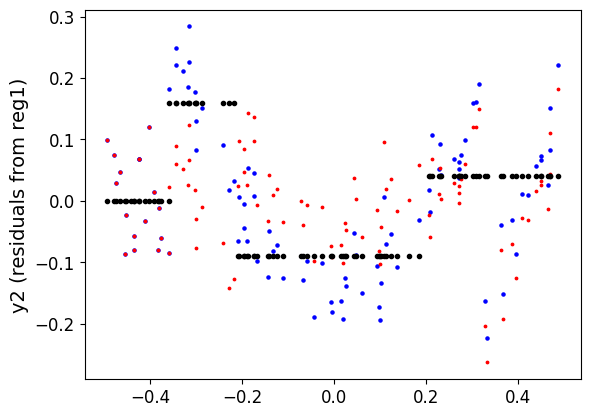

In [497]:
residual2 = y2 - yhat2
plt.scatter(X, y2, s=5, c='b')
plt.plot(X, yhat2, 'k.', )
plt.scatter(X, residual2, c='r', s=3)
plt.ylabel("y2 (residuals from reg1)")

In [498]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

Let's plot the predicted points `yhat3` over the original points `y3` to understand the fit.

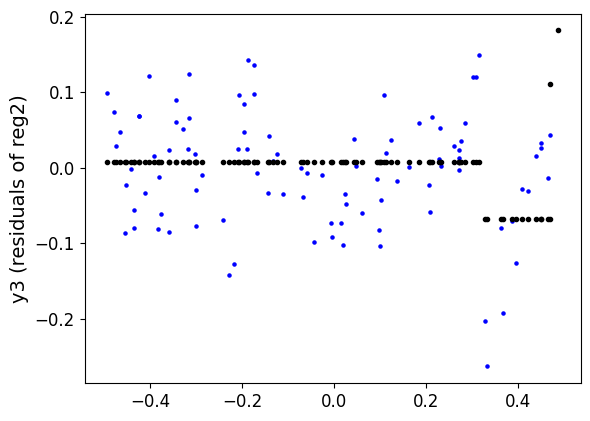

In [499]:
yhat3 = tree_reg3.predict(X)
plt.scatter(X, y3, c='b', s=5)
plt.plot(X, yhat3, 'k.')
plt.ylabel('y3 (residuals of reg2)')
plt.show()

Let's visualize the prediction made by the ensembled regressors.

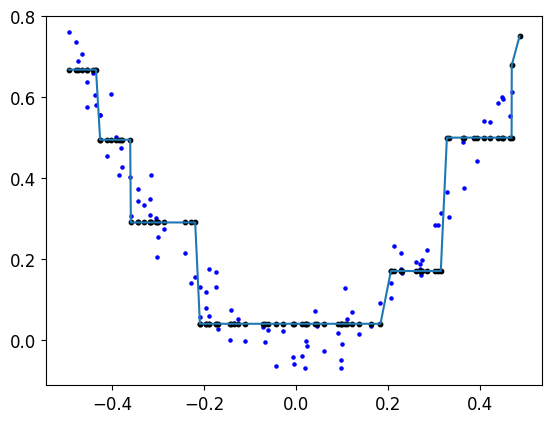

In [500]:
Xs = np.array(sorted(X))
y_pred = sum(tree.predict(Xs) for tree in (tree_reg1, tree_reg2, tree_reg3))
plt.scatter(X, y, s=5, c='b')
plt.scatter(Xs, y_pred, s=10, c='k')
plt.plot(Xs, y_pred)

Let's create an datapoint that's outside the training data and evaluate the prediction.

In [501]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

**In this depiction of Gradient Boosting, the first predictor (top left) is trained normally, then each consecutive predictor (middle left and lower left) is trained on the previous predictor’s residuals; the right column shows the resulting ensemble’s predictions:**

In [502]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure gradient_boosting_plot


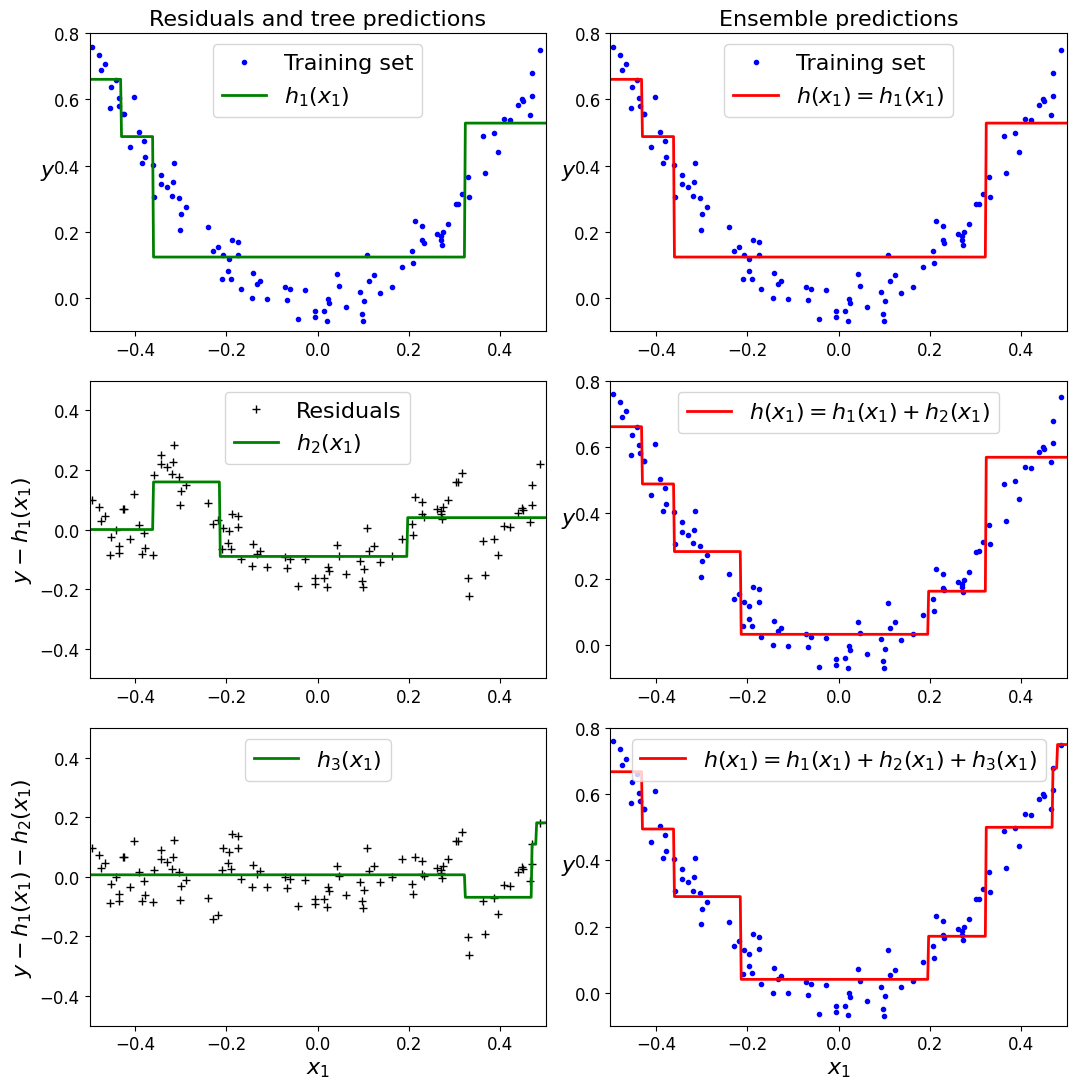

In [503]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

Now let's try a gradient boosting regressor.

The `learning_rate` hyperparameter scales the contribution of each tree. If you set it
to a low value, such as 0.05, you will need more trees in the ensemble to fit the
training set, but the predictions will usually generalize better. This is a regularization
technique called `shrinkage`.

In [504]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

GBRT ensembles trained with
different hyperparameters: the one on the left does not have enough trees to fit the
training set, while the one on the right has about the right amount. If we added more, the
GBRT would start to overfit the training set.

In [505]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

**GBRT ensembles with not enough predictors (left) and too many (right):**

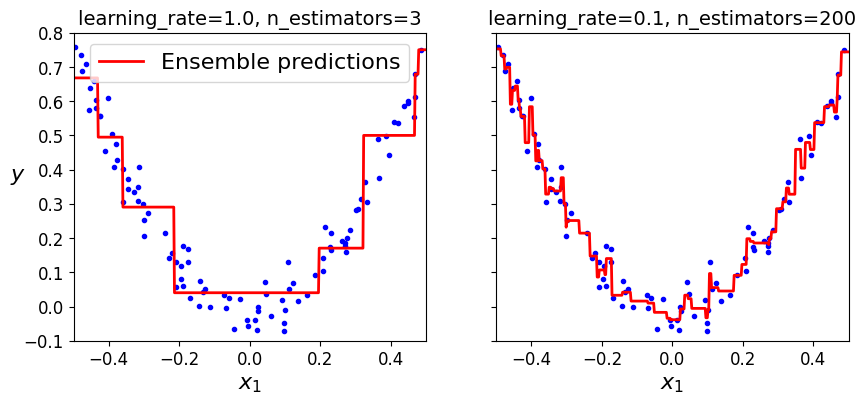

In [506]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

**Gradient Boosting with Early stopping:**

To find the optimal number of trees, you could perform cross-validation using
`GridSearchCV` or `RandomizedSearchCV`, as usual, but there’s a simpler way: if
you set the `n_iter_no_change` hyperparameter to an integer value, say 10, then the
`GradientBoostingRegressor` will automatically stop adding more trees during
training if it sees that the last 10 trees didn’t help. This is simply early stopping, 
but with a little bit of patience: it tolerates having no progress
for a few iterations before it stops.

In [512]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)
print("#estimators:", gbrt.n_estimators)

gbrt.fit(X_train, y_train)

errors = [root_mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

min_error = np.min(errors)
print("Linear Search min_error:", min_error)
print("Optimal #estimators via Linear Search:", bst_n_estimators)

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

# using the n_iter_no_change stopping criterion
gbrt_best_2 = GradientBoostingRegressor(max_depth=2, learning_rate=0.05, n_estimators=200, 
                                      n_iter_no_change=10, random_state=42)
gbrt_best_2.fit(X, y)
print("Optimal #estimators via n_iter_no_change:", gbrt_best_2.n_estimators_)

#estimators: 200
Linear Search min_error: 0.05208505856035359
Optimal #estimators via Linear Search: 56
Optimal #estimators via n_iter_no_change: 92


**Tuning the number of trees using early stopping:**

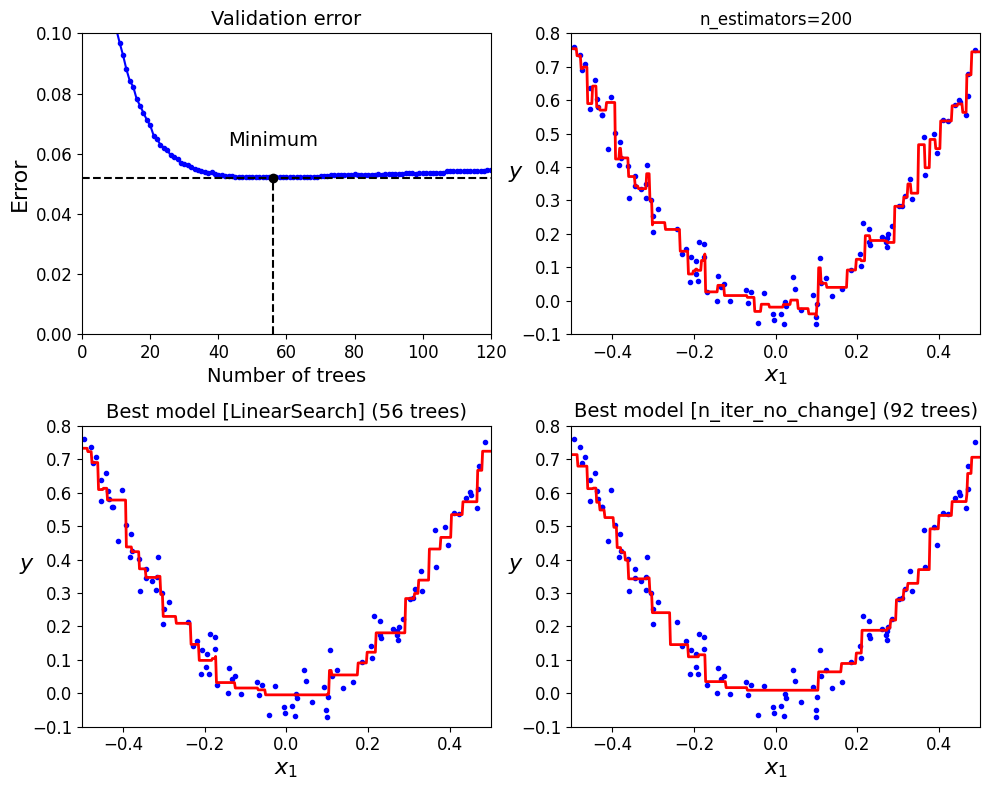

In [514]:
plt.figure(figsize=(10, 8))

plt.subplot(221)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.1])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(223)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model [LinearSearch] (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(222)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(f"n_estimators={gbrt.n_estimators_}")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(224)
plot_predictions([gbrt_best_2], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model [n_iter_no_change] (%d trees)" % gbrt_best_2.n_estimators_, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.tight_layout()
plt.show()

Early stopping with some patience (interrupts training only after there's no improvement for 5 epochs):

In [515]:
gbrt_patience = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt_patience.n_estimators = n_estimators
    gbrt_patience.fit(X_train, y_train)
    y_pred = gbrt_patience.predict(X_val)
    val_error = root_mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

print("Best #estimators with patience:", gbrt_patience.n_estimators)

gbrt_best_w_patience = GradientBoostingRegressor(max_depth=2, n_estimators=gbrt_patience.n_estimators, random_state=42)
gbrt_best_w_patience.fit(X_train, y_train)


Best #estimators with patience: 61


GradientBoostingRegressor(max_depth=2, n_estimators=61, random_state=42)

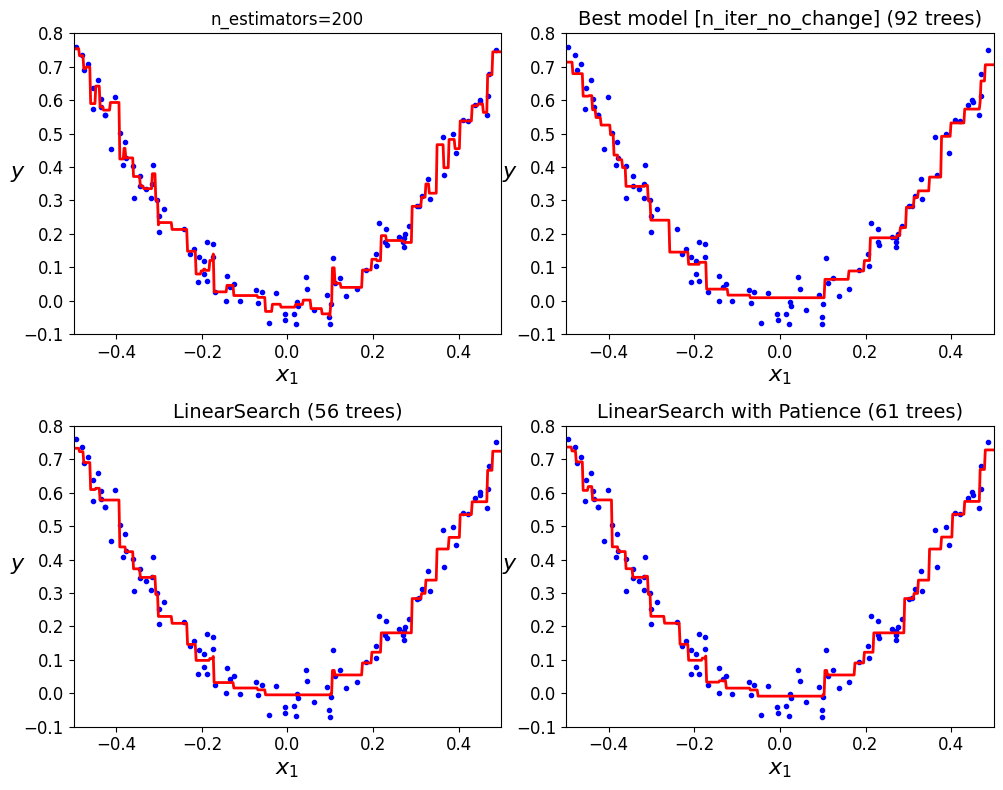

In [516]:
plt.figure(figsize=(10, 8))

plt.subplot(224)
plot_predictions([gbrt_best_w_patience], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("LinearSearch with Patience (%d trees)" % gbrt_patience.n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(223)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("LinearSearch (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(221)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(f"n_estimators={gbrt.n_estimators_}")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(222)
plot_predictions([gbrt_best_2], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model [n_iter_no_change] (%d trees)" % gbrt_best_2.n_estimators_, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.tight_layout()
plt.show()

**Using XGBoost:**

In [517]:
import xgboost

In [518]:
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)
val_error = root_mean_squared_error(y_val, y_pred) # Not shown
print("Validation MSE:", val_error)           # Not shown

Validation MSE: 0.06815041706634728


In [519]:
xgb_reg_1 = xgboost.XGBRegressor(random_state = 42, early_stopping_rounds = 10)
xgb_reg_1.fit(X_train, y_train, eval_set=[(X_val, y_val)])
y_pred = xgb_reg_1.predict(X_val)
val_error = root_mean_squared_error(y_val, y_pred)  # Not shown
print("Validation MSE:", val_error)            # Not shown

[0]	validation_0-rmse:0.15232
[1]	validation_0-rmse:0.10690
[2]	validation_0-rmse:0.07868
[3]	validation_0-rmse:0.06385
[4]	validation_0-rmse:0.05656
[5]	validation_0-rmse:0.05486
[6]	validation_0-rmse:0.05394
[7]	validation_0-rmse:0.05556
[8]	validation_0-rmse:0.05682
[9]	validation_0-rmse:0.05811
[10]	validation_0-rmse:0.05983
[11]	validation_0-rmse:0.06033
[12]	validation_0-rmse:0.06100
[13]	validation_0-rmse:0.06179
[14]	validation_0-rmse:0.06206
[15]	validation_0-rmse:0.06235
[16]	validation_0-rmse:0.06230
Validation MSE: 0.05393622756566418


In [520]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train)

29.8 ms ± 3.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [521]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

25.3 ms ± 579 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Stacking

Let's revisit our moon dataset and try to fit a Stacking Classifier on it.

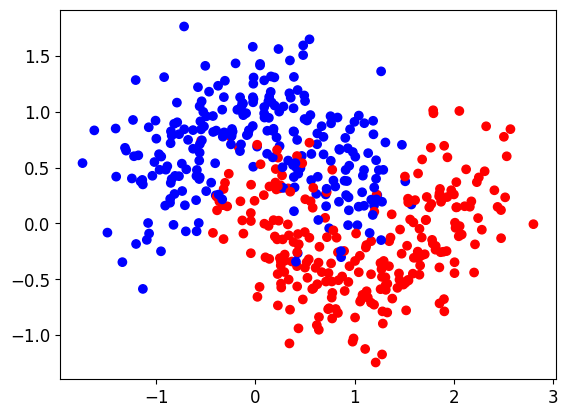

In [522]:
X_moon, y_moon = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_moon, y_moon, random_state=42)
plt.scatter(X_moon[:,0], X_moon[:,1], c=y_moon, cmap=colors.ListedColormap(["blue", "red"]))
plt.show()

The last Ensemble method we will discuss in this chapter is called stacking (short for
stacked generalization). It is based on a simple idea: instead of using trivial functions
(such as hard voting) to aggregate the predictions of all predictors in an ensemble, why
don’t we train a model to perform this aggregation? The following figure shows such an
ensemble performing a regression task on a new instance. Each of the bottom three
predictors predicts a different value (3.1, 2.7, and 2.9), and then the final predictor
(called a blender, or a meta learner) takes these predictions as inputs and makes the
final prediction (3.0).

![image.png](stacking.png)                      ![image.png](stacking2.png)

In [523]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[('lr', LogisticRegression(random_state=42)), 
                ('rf', RandomForestClassifier(random_state=42)), 
                ('svc', SVC(probability=True,random_state=42))],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5  # number of cross-validation folds
)
stacking_clf.fit(X_train_m, y_train_m)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

In [524]:
stacking_clf.score(X_test_m, y_test_m)

0.928

__Recall, the best performance for this dataset was less than the stacked classifier performance!__